In [1]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt

N_DIMS = 1 # Number of dimensions
BS = 64 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 42
tkwargs = {"device": "cpu", "dtype": torch.float64}

In [2]:
# Setting seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)

In [3]:
def forrester(x, noise=False):
    f = np.sin(3*x) + x**2 - 0.7*x + 1
    if noise:
        f += np.random.normal(0, .2, f.shape)
    return f

In [4]:
import math
from torch import nn
from collections import OrderedDict
from tqdm import trange
from botorch.utils.sampling import draw_sobol_samples


class AuxillaryClassifier(nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        num_units=32,
        num_layers=3,
        dropout=0.2,
        device="cpu",
        dtype=torch.float64,
    ):
        self.tkwargs = {"device": device, "dtype": dtype}

        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(p=dropout)
        self.num_layers = num_layers
        self.activation = nn.ELU()

        layers = []
        layers.append((f"layer_{0}", torch.nn.Linear(input_dim, num_units)))
        layers.append((f"activation_{0}", self.activation))
        layers.append((f"dropout_{0}", self.dropout))
        for i in range(1, num_layers):
            layers.append((f"layer_{i}", torch.nn.Linear(num_units, num_units)))
            layers.append((f"activation_{i}", self.activation))
            layers.append((f"dropout_{i}", self.dropout))
        layers.append((f"output_layer", torch.nn.Linear(num_units, output_dim)))

        self.bounds = torch.tensor([[-1.], [2.]], **tkwargs)
        self.model = torch.nn.Sequential(OrderedDict(layers))
        self.model.to(**tkwargs)

    def forward(self, x):
        logits = self.model(x)
        return logits

    def fit(self, X, batch_size=256, S=500):
        optimizer = torch.optim.Adam(self.model.parameters())
        loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

        x_p = X
       
        N = 2*len(X)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        self.model.train()
        losses = []
        for epochs in trange(E):
            x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]]), n=len(X), q=1).squeeze(1)
            x = torch.concat([x_p, x_m], axis=0)
            z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
            z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(1)
            z = torch.concat([z_p, z_m], axis=0)
            labels = torch.nn.functional.one_hot(z).to(x.dtype)

            s_p = x_p.shape[0]
            s_m = x_m.shape[0]
            w_p = torch.tensor(s_p * [(s_p + s_m) / s_m]).to(x.dtype)
            w_m = torch.tensor(s_m * [(s_p + s_m) / s_m]).to(x.dtype)
            w = torch.cat([w_p, w_m], axis=0)
            weights = w / w.mean()
        

            train_dataset = torch.utils.data.TensorDataset(x, z, w)
            train_dataloader = torch.utils.data.DataLoader(
                train_dataset,
                batch_size=batch_size,
                shuffle=True
            )
            for _, (inputs, labels, weights) in enumerate(train_dataloader):
                optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = loss_fn(
                    outputs, labels, 
                )
                batch_loss = ((weights * loss) / weights.sum()).sum()
                batch_loss.backward()
                optimizer.step()
                losses.append(batch_loss.item())

        self.model.eval()


def prepare_data_mdre(X, y, gamma, acq_type="ei"):
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)

    auxi_clf = AuxillaryClassifier(input_dim=1, output_dim=2, **tkwargs)
    auxi_clf.fit(X, batch_size=256, S=500)

    tau = torch.quantile(y, q=gamma)
    z = torch.less(y, tau)

    if acq_type == 'ei':
        x_p, y_p = X[z.squeeze()], y[z.squeeze()]
        w_p = (tau - y)[z]
        w_p = w_p / torch.mean(w_p)

        x_q, y_q = X, y
        x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=len(x_q), q=1).squeeze(1)
        x = torch.cat([x_p, x_q, x_m], axis=0)

        z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
        z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
        z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)
        z = torch.cat([z_p, z_q, z_m], axis=0)
        z_onehot = torch.nn.functional.one_hot(z).to(X.dtype)

        s_p = x_p.shape[0]
        s_q = x_q.shape[0]
        s_m = x_m.shape[0]

        w_p = w_p * (s_p + s_q + s_m) / s_p
        w_q = z_q * (s_p + s_q + s_m) / s_q
        w_m = z_q * (s_p + s_q + s_m) / s_m
        w = torch.cat([w_p, w_q, w_m], axis=0)
        with torch.no_grad():
            logits = auxi_clf(x)
        # probs = torch.nn.functional.softmax(logits, dim=1)
        importance_ratio = (logits[:, 1] - logits[:, 0]).exp()
#         importance_ratio = importance_ratio / importance_ratio.mean()
        w = importance_ratio * w
        w = w / w.mean()

    elif acq_type == 'pi':
        x_p, y_p = X[z.squeeze()], y[z.squeeze()]

        x_q, y_q = X[~z.squeeze()], y[~z.squeeze()]

        x_m = draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=int(len(X)/2), q=1).squeeze(1)
        x = torch.cat([x_p, x_q, x_m], axis=0)

        z_p = torch.empty(x_p.shape[0], dtype=torch.long).fill_(0)
        z_q = torch.empty(x_q.shape[0], dtype=torch.long).fill_(1)
        z_m = torch.empty(x_m.shape[0], dtype=torch.long).fill_(2)
        z = torch.cat([z_p, z_q, z_m], axis=0)
        z_onehot = torch.nn.functional.one_hot(z).to(X.dtype)

        s_p = x_p.shape[0]
        s_q = x_q.shape[0]
        s_m = x_m.shape[0]

        w = torch.ones(len(x), 1, **tkwargs)

    return x, z_onehot, w, tau


class MDRE(nn.Module):

    def __init__(
        self,
        input_dim,
        output_dim,
        num_units=32,
        num_layers=3,
        dropout=0.0,
        device="cpu",
        dtype=torch.float64,
    ):
        self.tkwargs = {"device": device, "dtype": dtype}

        super().__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.dropout = nn.Dropout(p=dropout)
        self.num_layers = num_layers
        self.activation = nn.ELU()

        layers = []
        layers.append((f"layer_{0}", torch.nn.Linear(input_dim, num_units)))
        layers.append((f"activation_{0}", self.activation))
        layers.append((f"dropout_{0}", self.dropout))
        for i in range(1, num_layers):
            layers.append((f"layer_{i}", torch.nn.Linear(num_units, num_units)))
            layers.append((f"activation_{i}", self.activation))
            layers.append((f"dropout_{i}", self.dropout))
        layers.append((f"output_layer", torch.nn.Linear(num_units, output_dim)))

        self.model = torch.nn.Sequential(OrderedDict(layers))
        self.model.to(**tkwargs)

    def forward(self, x):
        logits = self.model(x)
        return logits

    def fit(self, x, z, w, batch_size=256, S=500):
        optimizer = torch.optim.Adam(self.model.parameters())
        loss_fn = torch.nn.CrossEntropyLoss(reduction='none')

        train_tensors = [x, z, w]
        train_dataset = torch.utils.data.TensorDataset(*train_tensors)
        train_dataloader = torch.utils.data.DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        N = len(x)  # N-th iteration
        M = math.ceil(N / batch_size)  # Steps per epochs
        E = math.floor(S / M)

        self.model.train()
        losses = []
        for epochs in trange(E):
            for _, (inputs, targets, weights) in enumerate(train_dataloader):
                optimizer.zero_grad(set_to_none=True)

                outputs = self.model(inputs)
                batch_loss = loss_fn(
                    outputs, targets, 
                )
                batch_loss = (batch_loss * weights).mean()
                batch_loss.backward()
                optimizer.step()
                losses.append(batch_loss.item())

        self.model.eval()

In [5]:
dense_x = np.linspace(-1, 2, 1024).reshape(-1, 1)
dense_y = forrester(dense_x, noise=False)

In [6]:
def plot_step_through_mdre(X_obs, y_obs, z_obs, new_x, new_y, tau, dr, acf, ax_func, ax_acf):
    ax_func.plot(dense_x, dense_y, color='k', label="objective function")
    ax_func.axhline(tau, linestyle='--', color='tab:gray', alpha=.7, label=r'$\tau$')

    x_p = X_obs[z_obs[:, 0].bool()]
    y_p = y_obs[z_obs[:, 0].bool()]
    x_q = X_obs[z_obs[:, 1].bool()]
    y_q = y_obs[z_obs[:, 1].bool()]
    x_m = X_obs[z_obs[:, 2].bool()]
    
    ax_func.scatter(x_q, y_q, marker='x', color='tab:blue', label="bad")
    ax_func.scatter(x_p, y_p, marker='x', color='tab:red', label="good")
    ax_func.scatter(new_x, new_y, marker='*', label="new x", color='tab:orange', s=50)
    ax_func.scatter(dense_x, acf[:, 1], s=1, color='tab:blue',)
    ax_func.scatter(dense_x, acf[:, 0], s=1, color='tab:red',)
    ax_func.scatter(dense_x, acf[:, 2], s=1, color='tab:green',)
    ax_func.set_xlim(-1., 2.)
    ax_func.set_ylim(0, None)
    ax_func.set_title('MDRE')

    ax_func.plot(
        x_m,
        np.zeros(len(x_m)),
        '|',
        markersize=12,
        color="tab:green"
    )
    ax_acf.plot(
        dense_x.flatten(),
        dr,
        label=r"$\ell(x)$",
    )
    ax_acf.set_xlim(-1, 2)
#     ax_acf.set_ylim(0, None)
    ax_acf.set_xlabel('x')
    ax_acf.set_ylabel('log density ratio')

100%|██████████| 1000/1000 [00:00<00:00, 1134.98it/s]


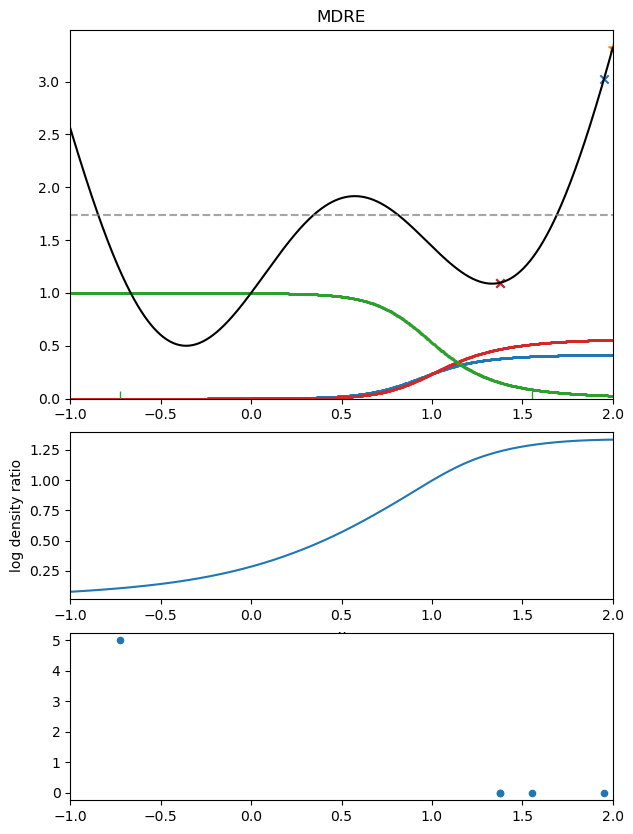

100%|██████████| 1000/1000 [00:01<00:00, 964.90it/s]


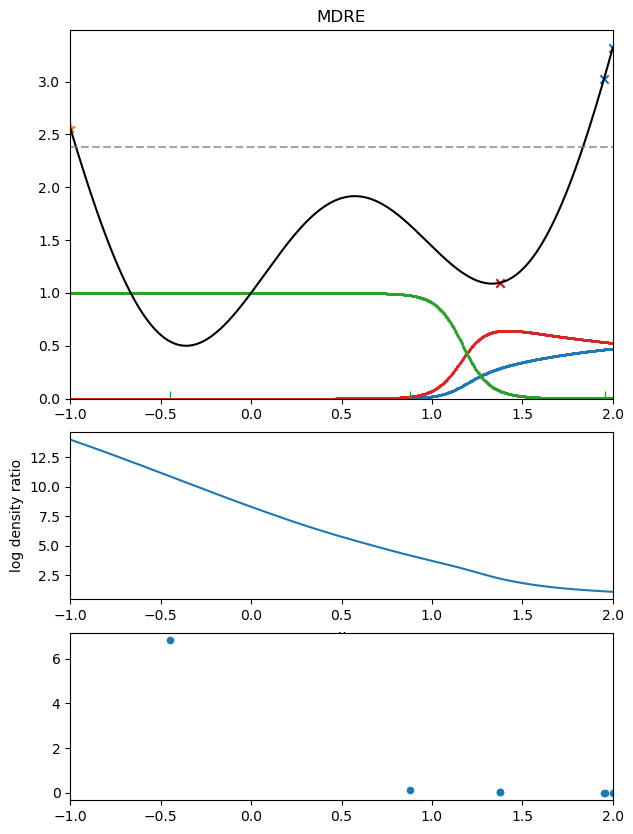

100%|██████████| 1000/1000 [00:00<00:00, 1085.95it/s]


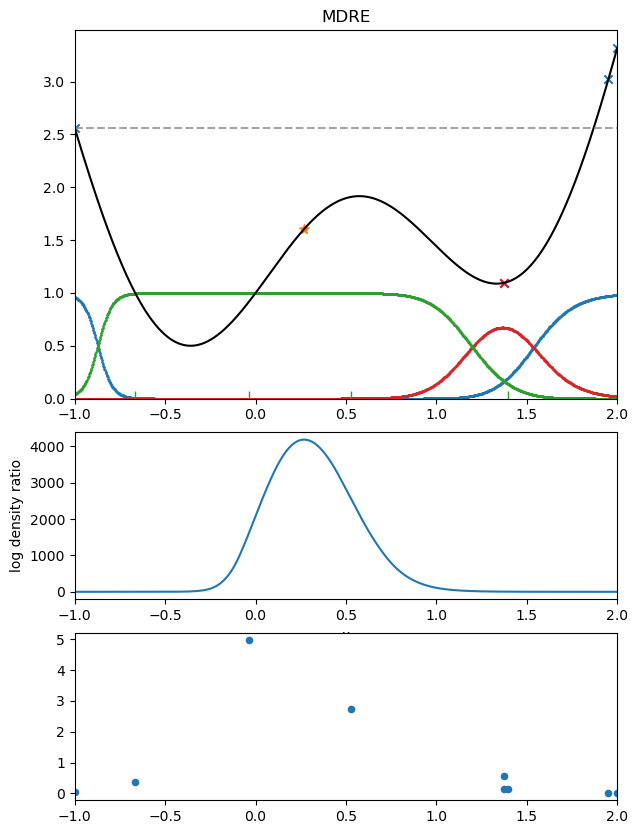

100%|██████████| 1000/1000 [00:01<00:00, 592.46it/s]


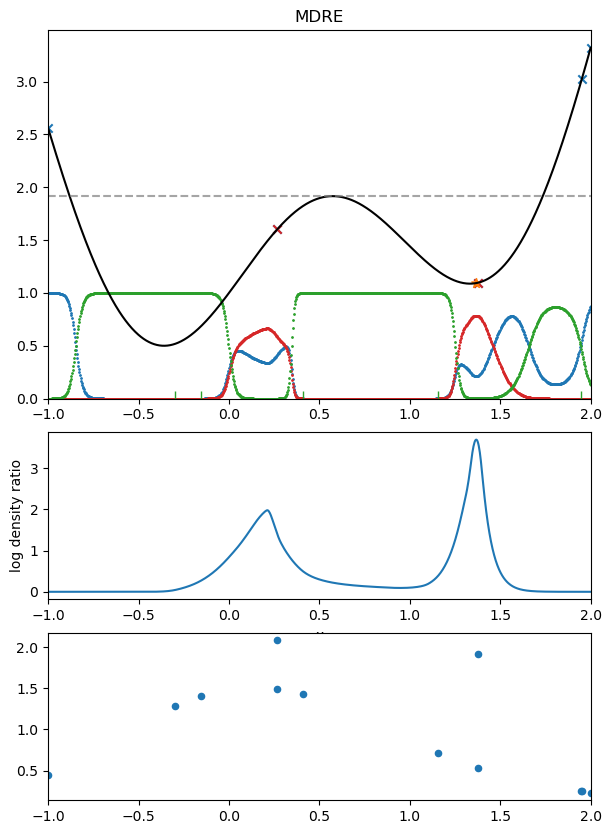

100%|██████████| 1000/1000 [00:01<00:00, 638.05it/s]


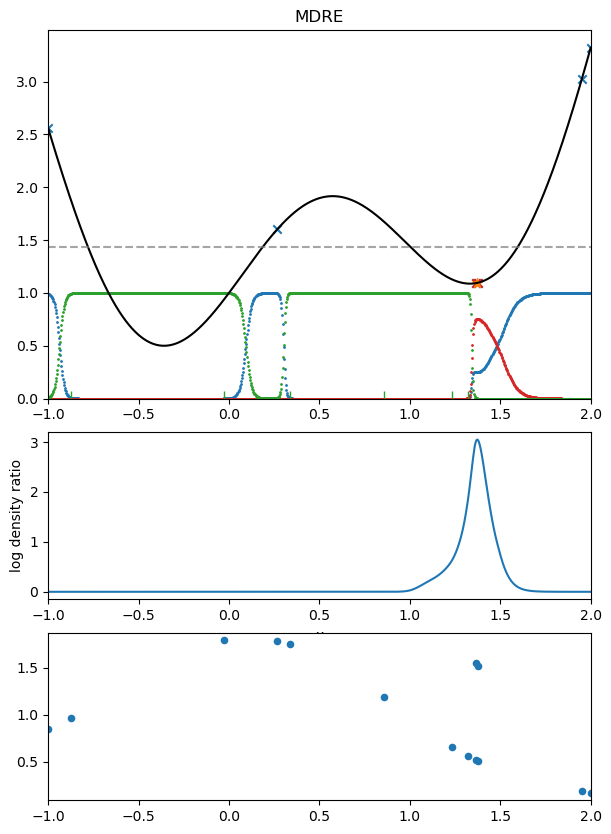

100%|██████████| 1000/1000 [00:01<00:00, 544.64it/s]


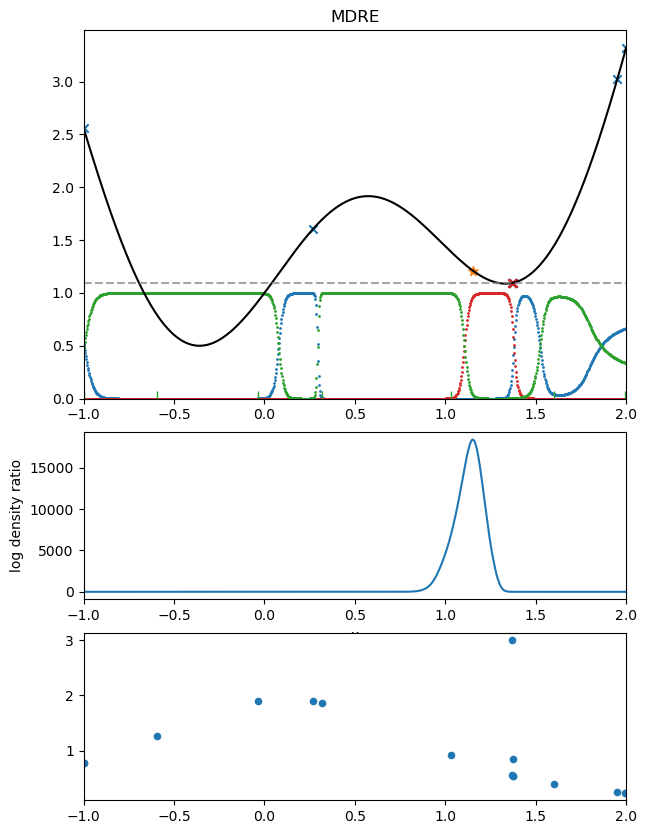

100%|██████████| 1000/1000 [00:01<00:00, 608.49it/s]


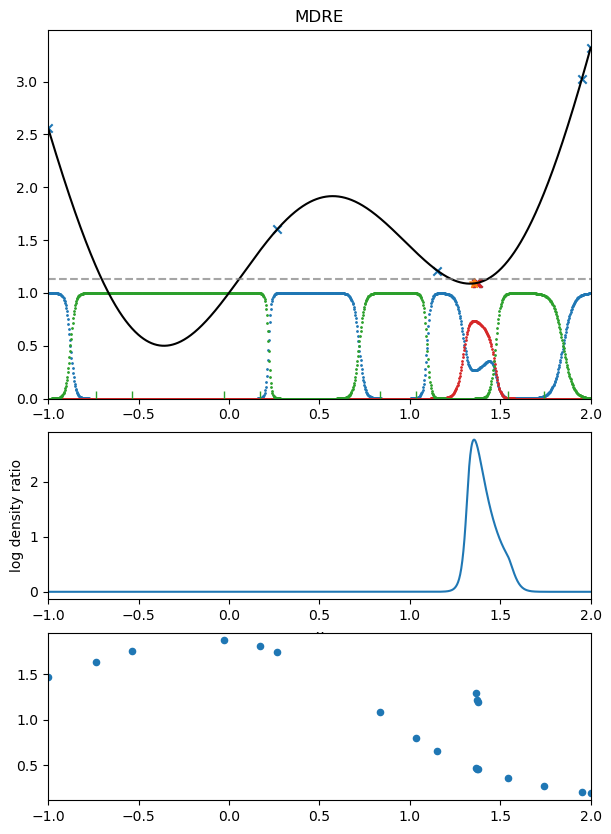

100%|██████████| 1000/1000 [00:01<00:00, 537.57it/s]


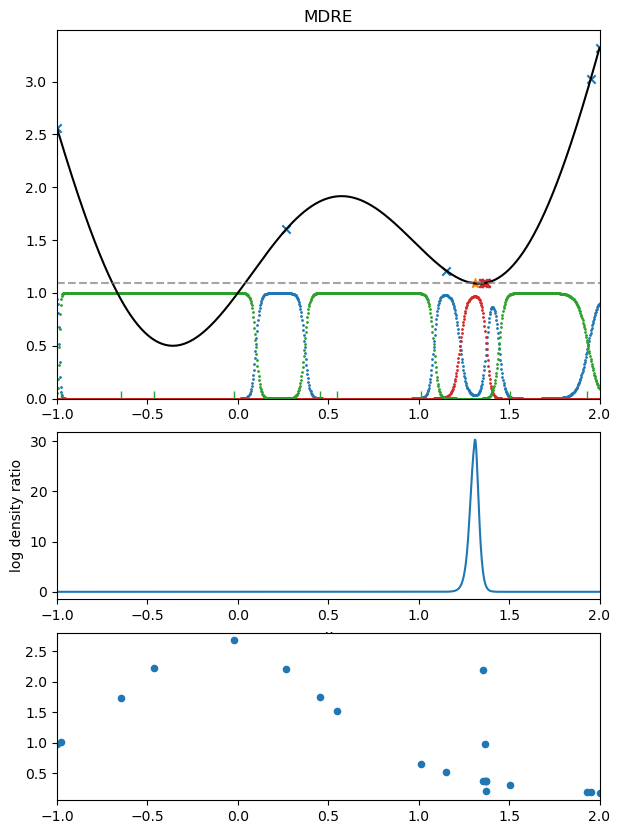

100%|██████████| 1000/1000 [00:01<00:00, 615.41it/s]


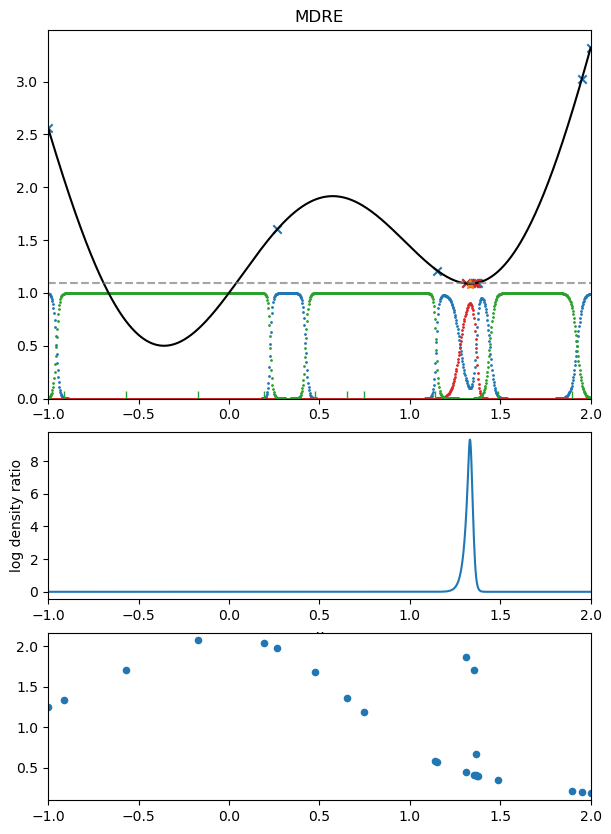

100%|██████████| 1000/1000 [00:01<00:00, 529.85it/s]


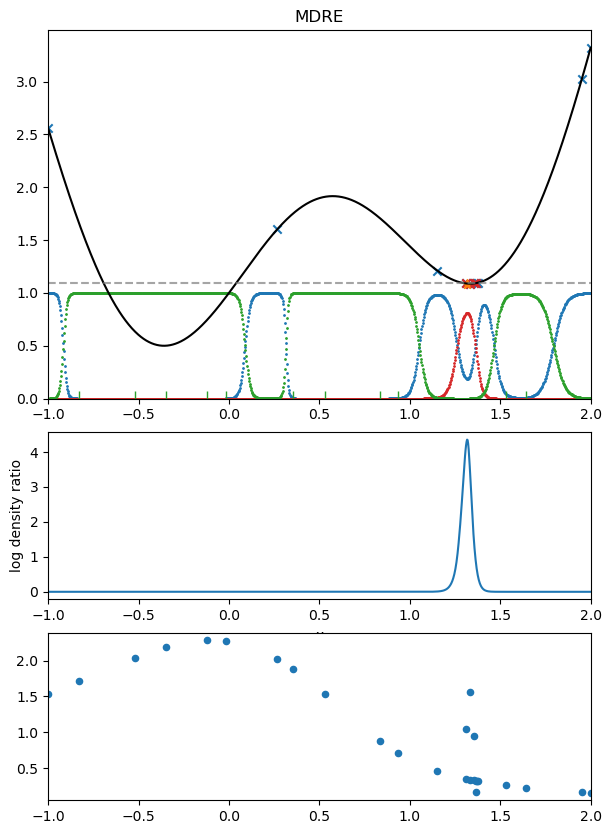

100%|██████████| 1000/1000 [00:01<00:00, 543.97it/s]


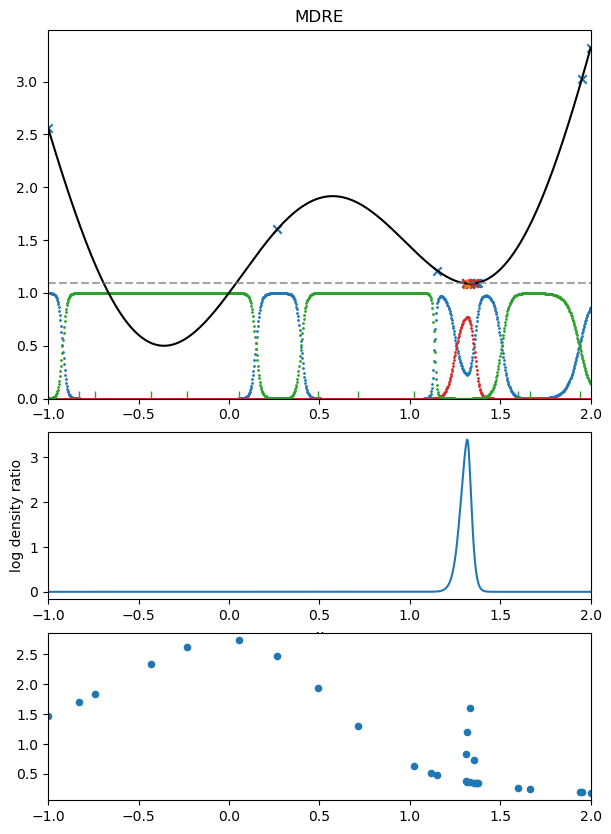

100%|██████████| 1000/1000 [00:01<00:00, 508.91it/s]


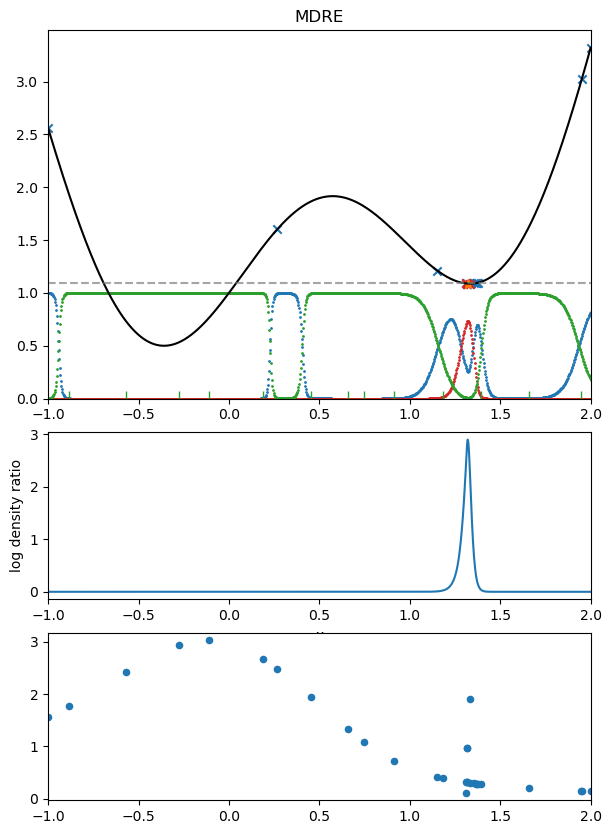

100%|██████████| 1000/1000 [00:01<00:00, 558.21it/s]


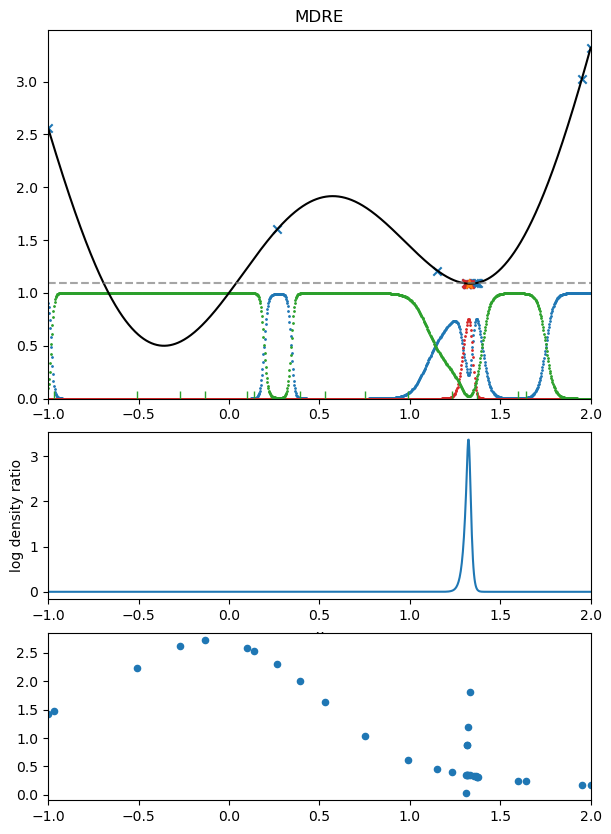

100%|██████████| 1000/1000 [00:01<00:00, 522.65it/s]


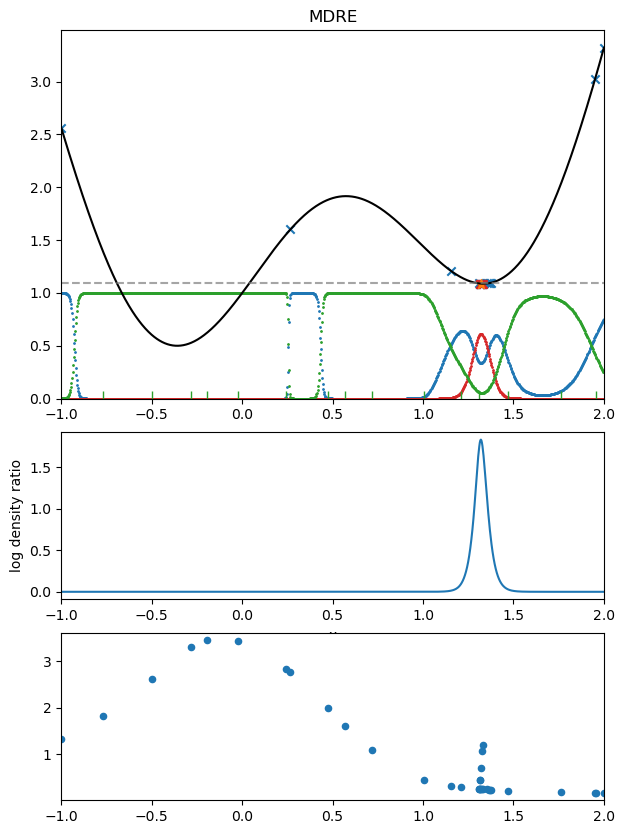

100%|██████████| 1000/1000 [00:02<00:00, 471.64it/s]


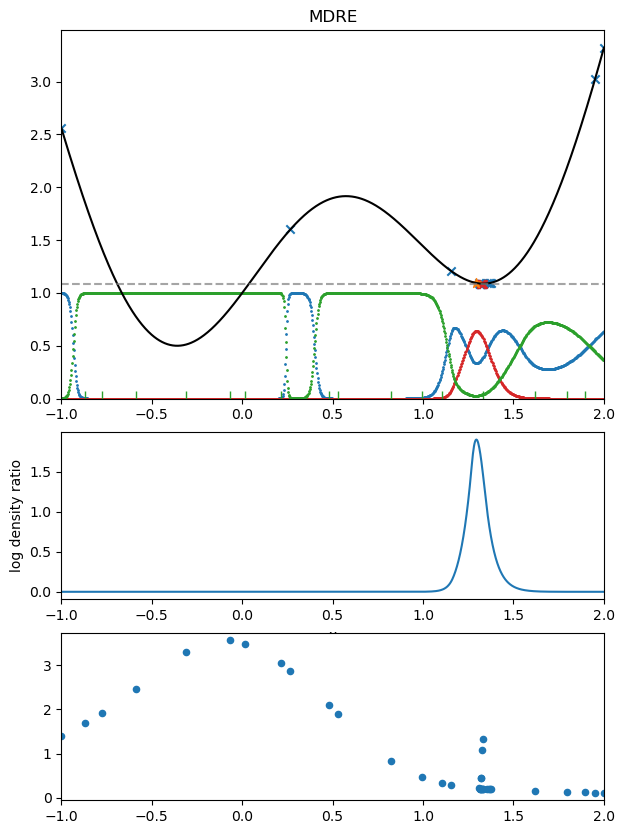

100%|██████████| 1000/1000 [00:01<00:00, 531.67it/s]


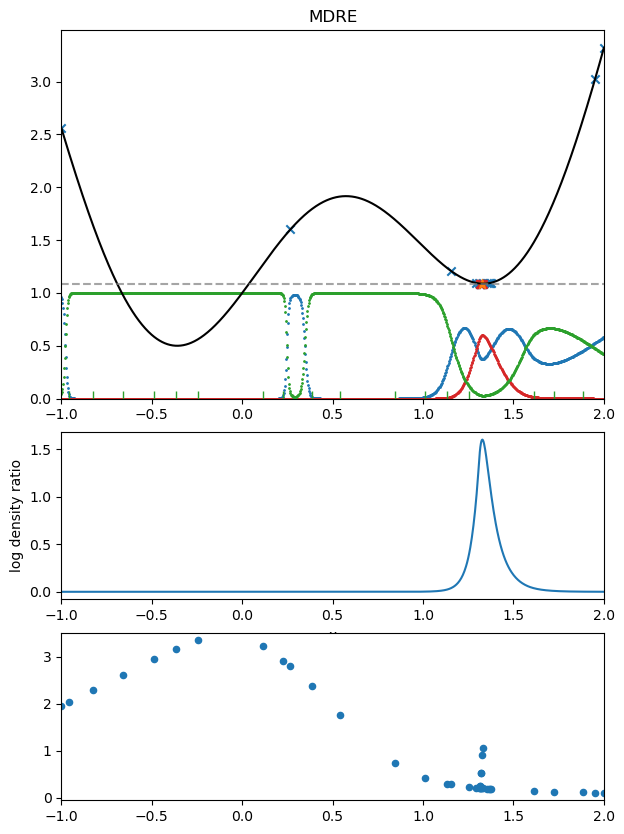

100%|██████████| 1000/1000 [00:01<00:00, 533.50it/s]


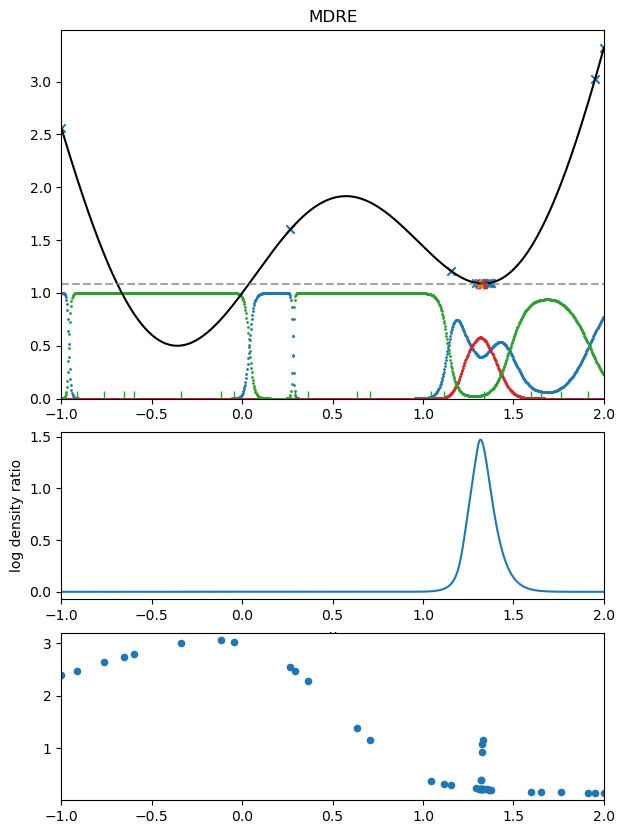

100%|██████████| 1000/1000 [00:03<00:00, 288.07it/s]


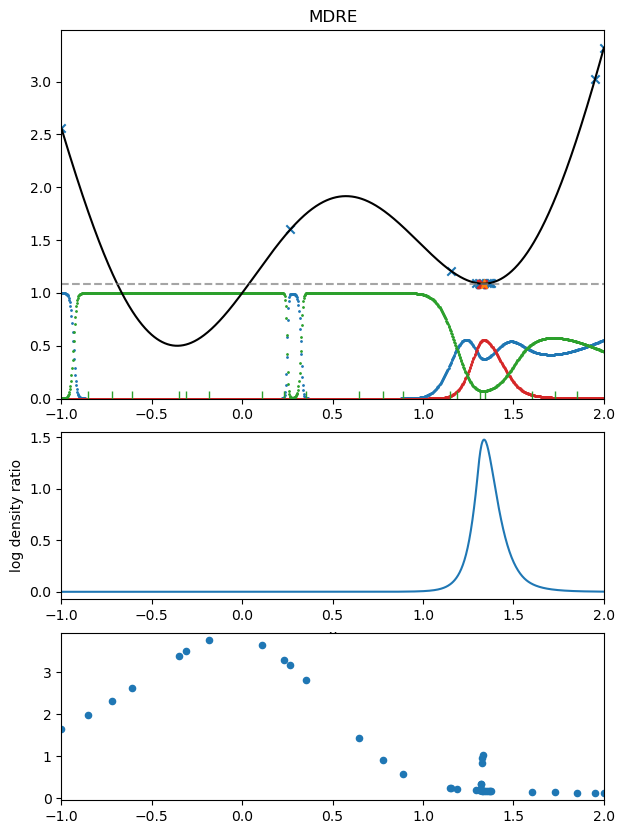

100%|██████████| 1000/1000 [00:01<00:00, 632.96it/s]


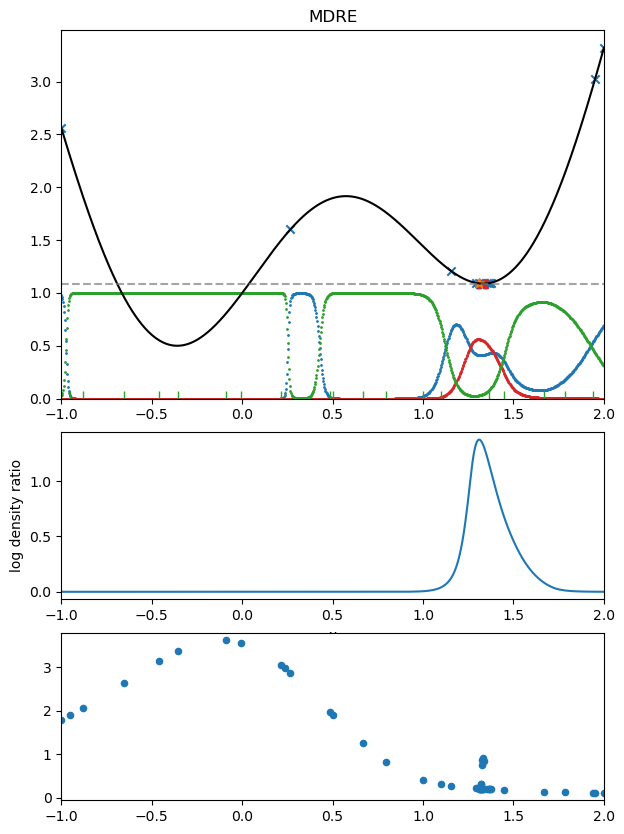

100%|██████████| 1000/1000 [00:01<00:00, 645.33it/s]


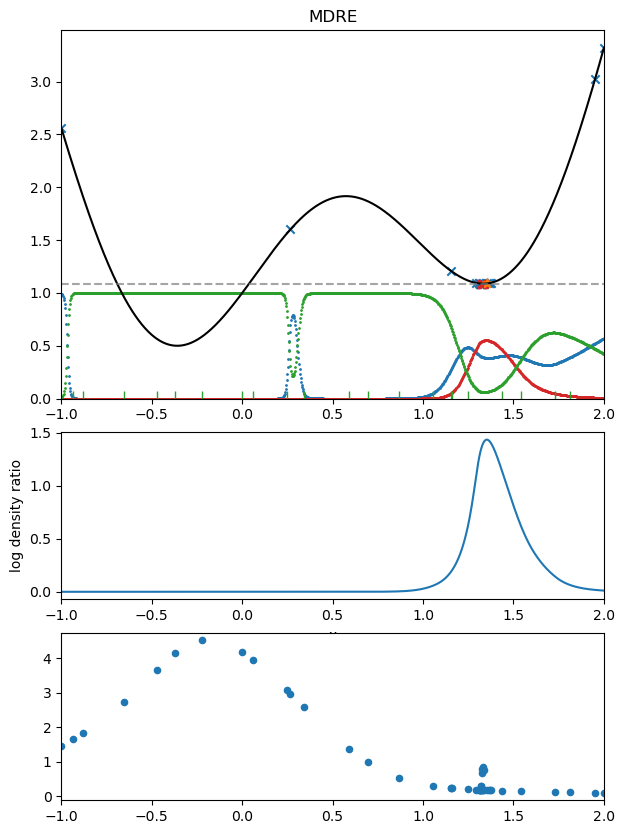

100%|██████████| 1000/1000 [00:01<00:00, 657.95it/s]


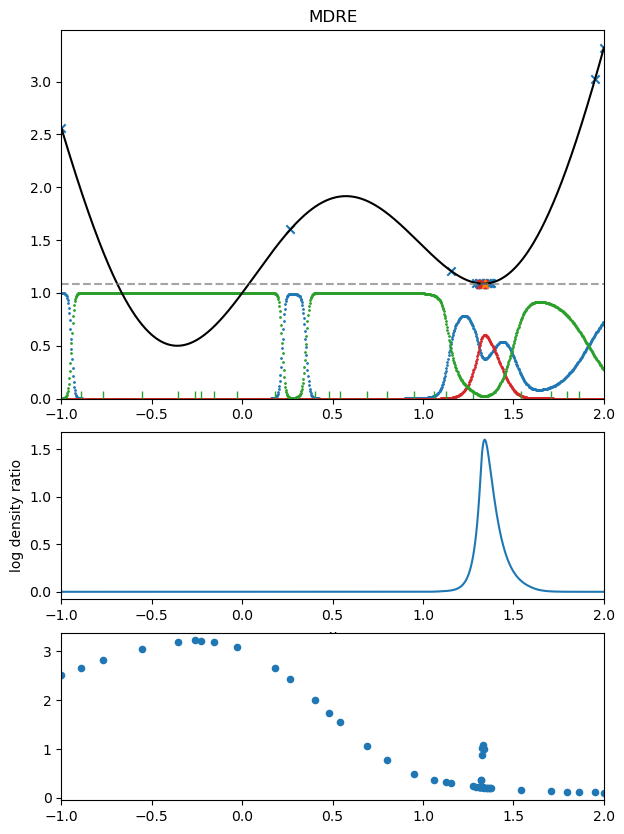

100%|██████████| 1000/1000 [00:01<00:00, 518.70it/s]


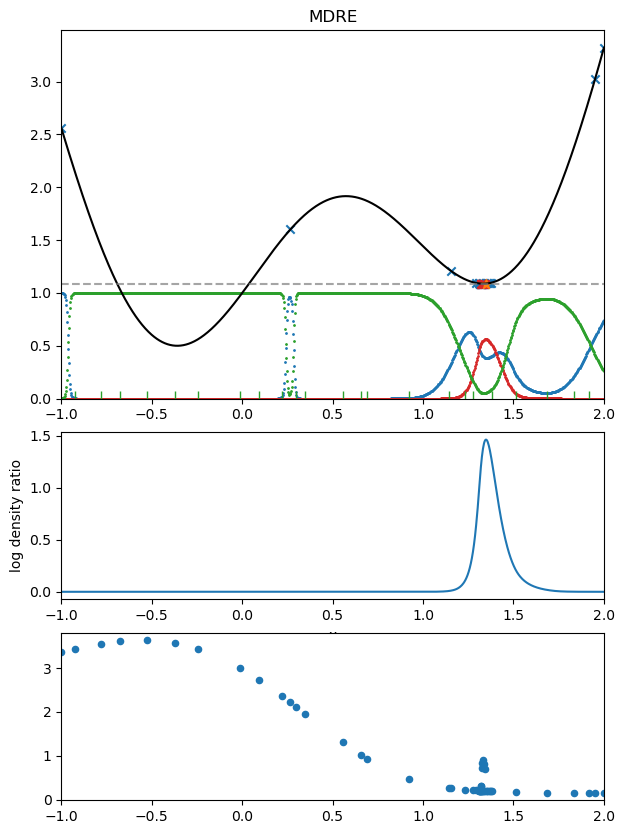

100%|██████████| 1000/1000 [00:01<00:00, 607.09it/s]


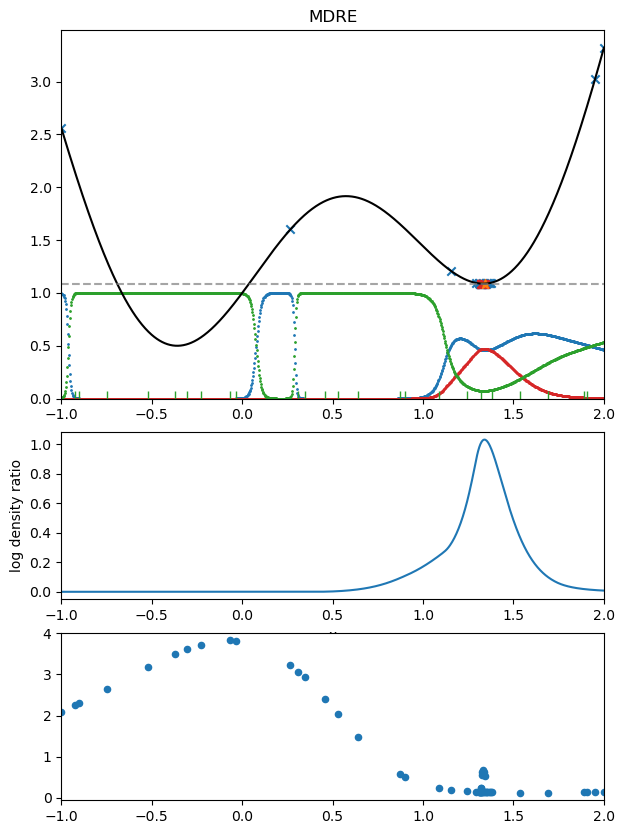

100%|██████████| 1000/1000 [00:01<00:00, 552.31it/s]


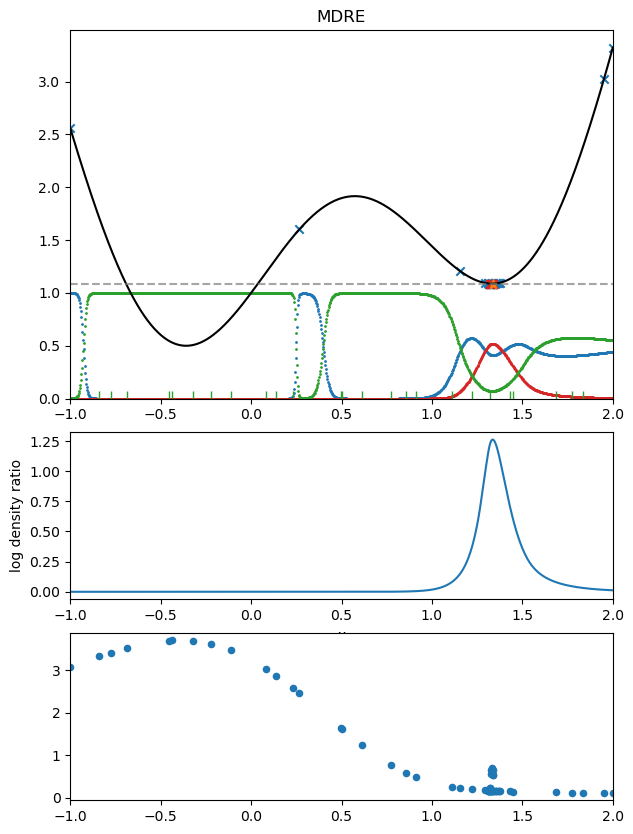

100%|██████████| 1000/1000 [00:02<00:00, 484.59it/s]


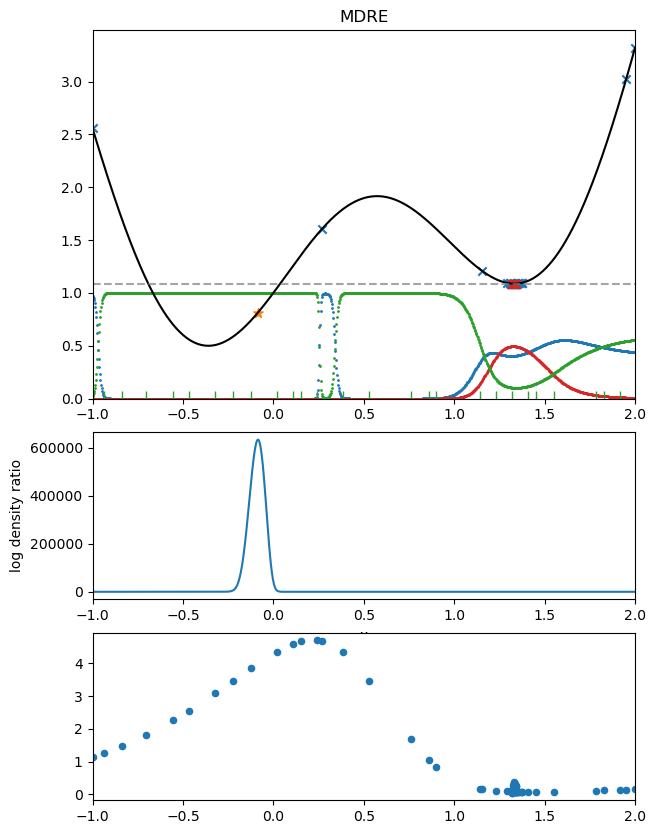

100%|██████████| 1000/1000 [00:01<00:00, 596.09it/s]


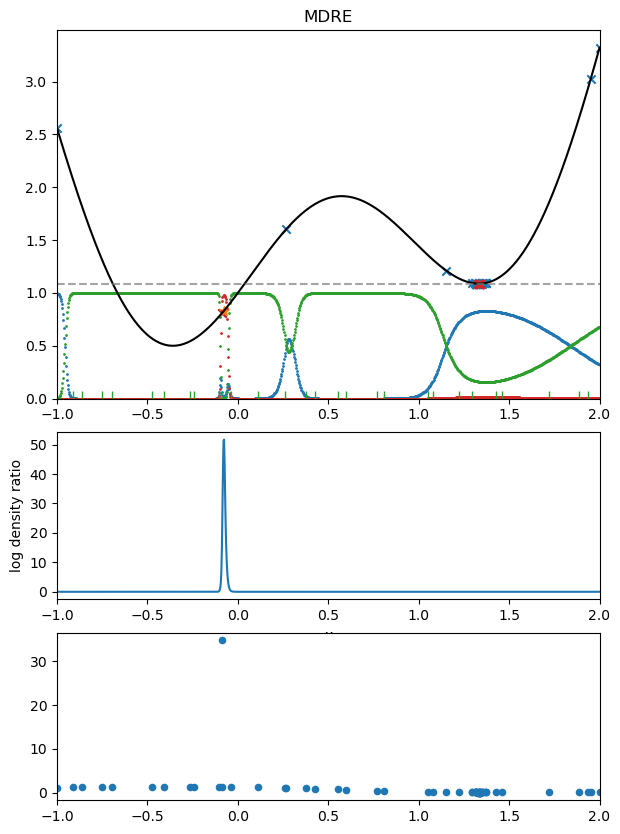

100%|██████████| 1000/1000 [00:02<00:00, 392.86it/s]


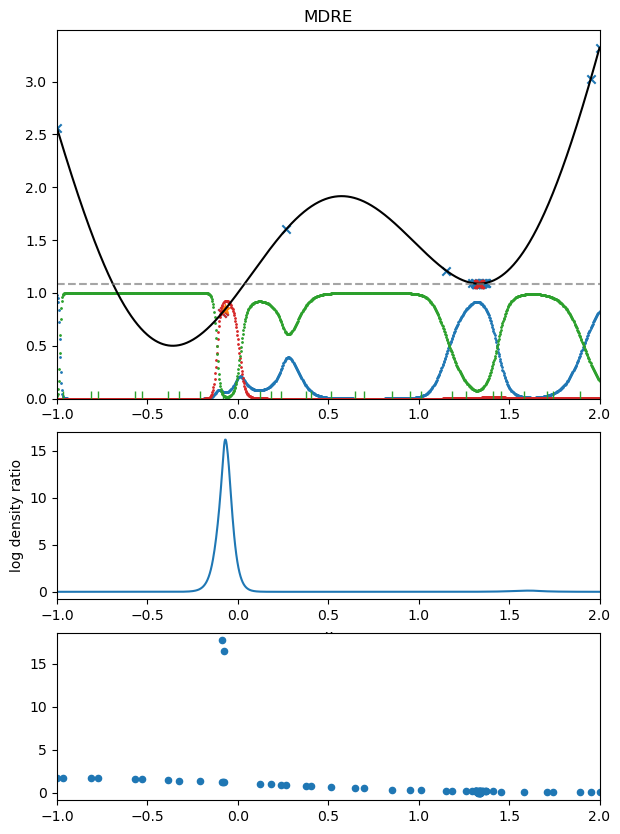

100%|██████████| 1000/1000 [00:02<00:00, 392.89it/s]


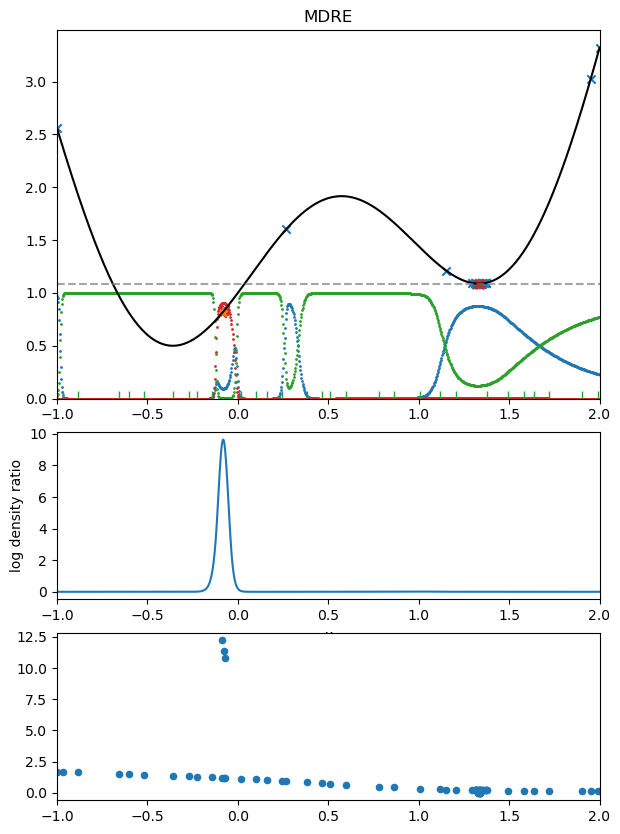

100%|██████████| 1000/1000 [00:02<00:00, 402.46it/s]


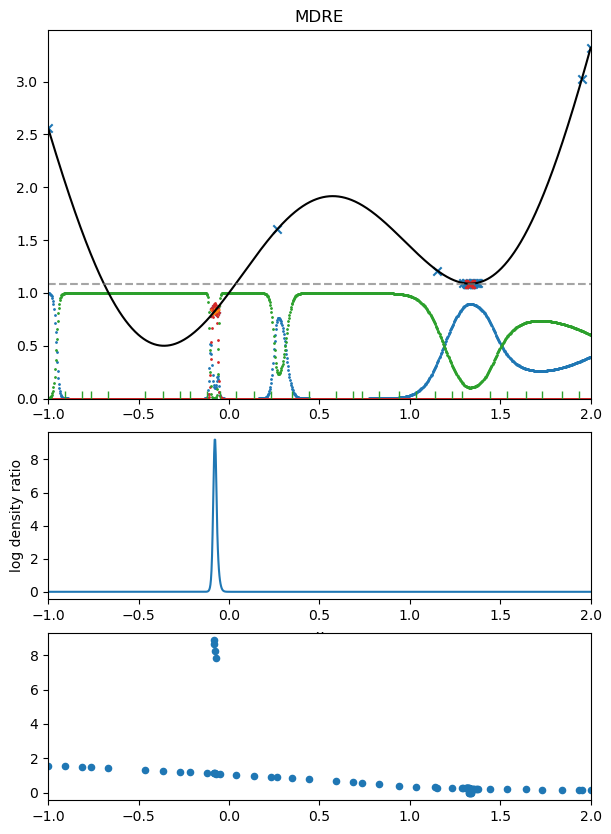

100%|██████████| 1000/1000 [00:02<00:00, 400.72it/s]


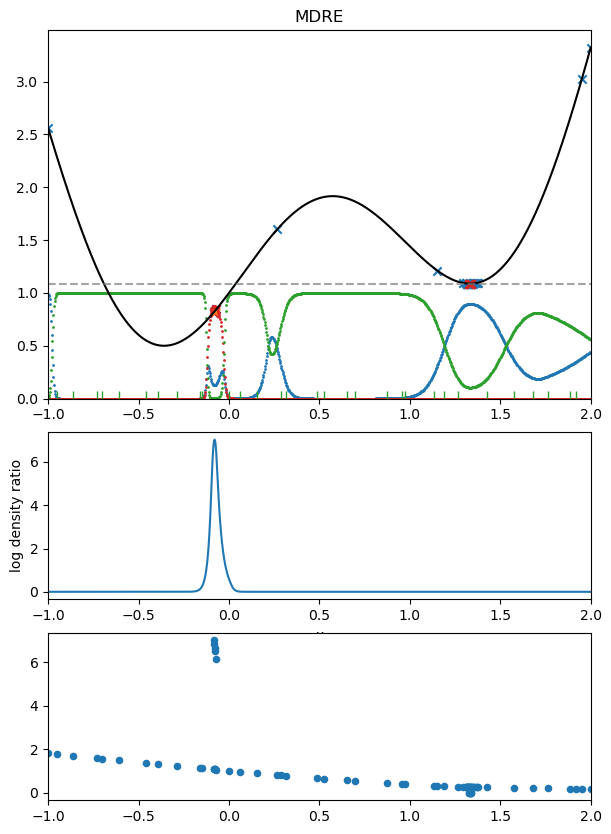

In [7]:
X_obs = np.random.uniform(1, 2, (2, 1))
y_obs = forrester(X_obs, noise=False)

X_obs_mdre, y_obs_mdre = X_obs, y_obs

num_evaluations = 30
GAMMA = 1/3

# def kl_divergence():

#     with torch.no_grad():
#         log_prob = auxi_clf(draw_sobol_samples(bounds=torch.tensor([[-1.], [2.]], **tkwargs), n=1024, q=1).squeeze(1))
#     log_ratio = log_prob[:, 1] - log_prob[:, 0] 

#     kl = log_ratio.mean()
#     return kl

mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
for n in range(num_evaluations):
    
    fig = plt.figure(figsize=(7, 10))
    ax_func_mdre = plt.subplot2grid((4, 1), (0, 0), rowspan=2)
    ax_acf_mdre = plt.subplot2grid((4, 1), (2, 0), rowspan=1)
    ax_weight = plt.subplot2grid((4, 1), (3, 0), rowspan=1)

    # mdre
    X_train_mdre, z_train_mdre, weight, tau = prepare_data_mdre(X_obs_mdre, y_obs_mdre, gamma=GAMMA, acq_type='ei')

    # print(kl_divergence())
    # print((1 - (- kl_divergence()).exp()))
    mdre = MDRE(input_dim=1, output_dim=3, **tkwargs)
    y_train_mdre = forrester(X_train_mdre)
    mdre.fit(X_train_mdre, z_train_mdre, weight, S=1000)
    with torch.no_grad():
        mdre_preds = mdre(torch.from_numpy(dense_x))
    acf_mdre = torch.nn.functional.softmax(mdre_preds, dim=-1)
    # dr_mdre = acf_mdre[:, 0] + (1 - (- kl_divergence()).exp()) * acf_mdre[:, 2]
    dr_mdre = (mdre_preds[:, 0] - mdre_preds[:, 1]).exp()
#     dr_mdre = (mdre_preds[:, 2] - mdre_preds[:, 1]).exp() + (mdre_preds[:, 0] - mdre_preds[:, 1]).exp()
    new_x = dense_x[np.argmax(dr_mdre)]
    new_y = forrester(new_x, noise=False)
    plot_step_through_mdre(X_train_mdre, y_train_mdre, z_train_mdre, new_x, new_y, tau, dr_mdre, acf_mdre, ax_func_mdre, ax_acf_mdre)
    X_obs_mdre = np.concatenate([X_obs_mdre, new_x.reshape(-1, 1)])
    y_obs_mdre = np.concatenate([y_obs_mdre, new_y.reshape(-1, 1)])

    ax_weight.scatter(X_train_mdre, weight, s=20, )
    ax_weight.set_xlim(-1, 2)

    plt.show()